In [1]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda, Dropout, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from sklearn.utils import shuffle
import numpy as np
import pickle
from glob import glob
import os
import pickle
from glob import iglob
import numpy as np
import librosa
import shutil
import pandas as pd
import os.path
from os import path
from tqdm import tqdm
from sklearn.metrics import classification_report

In [4]:
class ravdess_emodb_emotion_recog: 
    #Initialize the parameters and the dataset
    def __init__(self,dataset = "ravdess", num_classes=2,x_te=None,y_te = None,x_tr=None,y_tr=None):
        self.target_sr = 8000
        self.audio_length = 24000
        self.num_classes = num_classes
        self.x_test,self.y_test = x_te,y_te
        self.x_train,self.y_train = x_tr,y_tr
            
        if dataset == "ravdess":
            self.data_dir = '/home/fya7/data/'
            self.total_num_files = 1440
            self.emotions_dict, self.intensity_dict,self.class_ids, self.emotions_dict_m,self.emotions_dict_f= self.get_ravdess_dics(num_classes)
            self.df = self.create_ravdess_df()
        else:
            self.data_dir = '/home/fya7/emodb_dataset/wav/'
            self.total_num_files = 535
            self.emotions_dict, self.intensity_dict,self.class_ids, self.emotions_dict_m,self.emotions_dict_f= self.get_emodb_dict(num_classes)
            self.df = self.create_emodb_df()
    #Get the motions dictionary for emodb if it was selected for the processing  
    def get_emodb_dict(self, num_classes):
        emotions_dict, intensity_dict,class_ids, emotions_dict_m, emotions_dict_f = {},{},{},{},{}
        if num_classes == 4:
            emotions_dict = {
                'W': ['negative',0],
                'L': ['negative',0],
                'E': ['negative',0],
                'A': ['fear',2],
                'F': ['positive',1],
                'T': ['negative',0],
                'N': ['neutral',3],
            }

            class_ids = {
                'negative': 0,
                'positive': 1,
                'fear': 2,
                'neutral': 3
            }
        if num_classes == 7:
            emotions_dict = {
                'W': ['angry',0],
                'L': ['bored',1],
                'E': ['disgust',2],
                'A': ['fear',3],
                'F': ['happy',4],
                'T': ['sad',5],
                'N': ['neutral',6],
            }

            class_ids = {
                'angry': 0,
                'bored': 1,
                'disgust': 2,
                'fear': 3,
                'happy': 4,
                'sad': 5,
                'neutral': 6
            }
        if num_classes == 14:
            emotions_dict_m = {
                'W': ['angry',0],
                'L': ['bored',1],
                'E': ['disgust',2],
                'A': ['fear',3],
                'F': ['happy',4],
                'T': ['sad',5],
                'N': ['neutral',6],
            }
            emotions_dict_f = {
                'W': ['angry',7],
                'L': ['bored',8],
                'E': ['disgust',9],
                'A': ['fear',10],
                'F': ['happy',11],
                'T': ['sad',12],
                'N': ['neutral',13],
            }
            class_ids = {
                'm-angry': 0,
                'm-bored': 1,
                'm-disgust': 2,
                'm-fear': 3,
                'm-happy': 4,
                'm-sad': 5,
                'm-neutral': 6,
                'f-angry': 7,
                'f-bored': 8,
                'f-disgust': 9,
                'f-fear': 10,
                'f-happy': 11,
                'f-sad': 12,
                'f-neutral': 13
            }
                      
        return emotions_dict, intensity_dict,class_ids, emotions_dict_m, emotions_dict_f
    #Get the motions dictionary for ravdess if it was selected for the processing     
    def get_ravdess_dics(self, num_classes):
        emotions_dict_m = {}
        emotions_dict_f = {}
        emotions_dict = {}
        if num_classes == 2:
            emotions_dict = {
                '01': ['neutral',0],
                '02': ['calm',0],
                '03': ['happy',1],
                '04': ['sad',2],
                '05': ['angry',3],
                '06': ['fearful',4],
                '07': ['disgust',5],
                '08': ['surprised',6]
            }
            intensity_dict = {
                '01': ['normal',0],
                '02': ['strong',1]
            }

            class_ids = {
                'neutral': 0,
                'calm': 0,
                'happy': 1,
                'sad': 2,
                'angry': 3,
                'fearful': 4,
                'disgust': 5,
                'surprised': 6,
            }
        if num_classes == 4:
            emotions_dict = {
                '01': ['positive',0],
                '02': ['positive',0],
                '03': ['positive',0],
                '04': ['negative',1],
                '05': ['negative',1],
                '06': ['fearful',2],
                '07': ['negative',1],
                '08': ['surprised',3]
            }
            intensity_dict = {
                '01': ['normal',0],
                '02': ['strong',1]
            }
            class_ids = {
            'positive': 0,
            'negative': 1,
            'fearful': 2,
            'surprised': 3
            }
        if num_classes ==14:
            emotions_dict_m = {
                '01': ['neutral',0],
                '02': ['calm',0],
                '03': ['happy',1],
                '04': ['sad',2],
                '05': ['angry',3],
                '06': ['fearful',4],
                '07': ['disgust',5],
                '08': ['surprised',6]
            }
            emotions_dict_f = {
                '01': ['neutral',7],
                '02': ['calm',7],
                '03': ['happy',8],
                '04': ['sad',9],
                '05': ['angry',10],
                '06': ['fearful',11],
                '07': ['disgust',12],
                '08': ['surprised',13]
            }
            intensity_dict = {
                '01': ['normal',0],
                '02': ['strong',1]
            }

            class_ids = {
                'm_neutral': 0,
                'm_calm': 0,
                'm_happy': 1,
                'm_sad': 2,
                'm_angry': 3,
                'm_fearful': 4,
                'm_disgust': 5,
                'm_surprised': 6,
                'm_neutral': 7,
                'm_calm': 7,
                'm_happy': 8,
                'm_sad': 9,
                'm_angry': 10,
                'm_fearful': 11,
                'm_disgust': 12,
                'm_surprised': 13,
            }
        if num_classes ==8:
            emotions_dict_m = {
                '01': ['positive',0],
                '02': ['positive',0],
                '03': ['positive',0],
                '04': ['negative',1],
                '05': ['negative',1],
                '06': ['fearful',2],
                '07': ['negative',1],
                '08': ['surprised',3]
            }
            emotions_dict_f = {
                '01': ['positive',4],
                '02': ['positive',4],
                '03': ['positive',4],
                '04': ['negative',5],
                '05': ['negative',5],
                '06': ['fearful',6],
                '07': ['negative',5],
                '08': ['surprised',7]
            }
            intensity_dict = {
                '01': ['normal',0],
                '02': ['strong',1]
            }

            class_ids = {
                'm_positive': 0,
                'm_negative': 1,
                'm_fearful': 2,
                'm_surprised': 3,
                'f_positive': 4,
                'f_negative': 5,
                'f_fearful': 6,
                'f_surprised': 7
            }
            
        return emotions_dict, intensity_dict,class_ids, emotions_dict_m, emotions_dict_f
    #Create RAVDESS dataframe
    def create_ravdess_df(self):
        df = pd.DataFrame(columns=['filename', 'gender','intensity','emotion'])
        a = ["train/","test/"]
        for i in range(2):
            folder = self.data_dir+a[i]
            subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
            for subfolder in tqdm(subfolders):
                for file in os.scandir(subfolder):
                    fpath = file.path
                    filenameorg = file.name
                    filename = filenameorg.replace(".wav", "")
                    labels = filename.split("-")
                    # odd number is male 1 female 0
                    gender_l = 0 if int(labels[6])%2 == 0 else 1
                    if self.num_classes ==8 or self.num_classes ==14:
                        if gender_l == 0:
                            df.loc[len(df)-1] = np.array([fpath, gender_l,self.intensity_dict[labels[3]][1],self.emotions_dict_f[labels[2]][0]])
                        else:
                            df.loc[len(df)-1] = np.array([fpath, gender_l,self.intensity_dict[labels[3]][1],self.emotions_dict_m[labels[2]][0]])
                    else:
                        df.loc[len(df)-1] = np.array([fpath, gender_l,self.intensity_dict[labels[3]][1],self.emotions_dict[labels[2]][1]])
        return df
    #Create Emodb dataframe
    def create_emodb_df(self):
        df = pd.DataFrame(columns=['filename', 'gender','emotion'])
        folder = '/home/fya7/emodb_dataset/wav/'
        for file in os.scandir(folder):
                fpath = file.path
                filenameorg = file.name
                filename = filenameorg.replace(".wav", "")
                print(filename)
                # odd number is male 1 female 0
                gender_l = 0 if filename[0:2] in '0310111215' else 1
                if gender_l == 0:
                    df.loc[len(df)-1] = np.array([fpath, gender_l,self.emotions_dict_f[filename[5]][0]])
                else:
                    df.loc[len(df)-1] = np.array([fpath, gender_l,self.emotions_dict_m[filename[5]][0]])     
        return df
    
    def extract_class_id(self, wav_filename):
        return int(self.df[self.df["filename"]==wav_filename]["emotion"].values[0])

    def extract_intensity_id(self, wav_filename):
        return int(self.df[self.df["filename"]==wav_filename]["intensity"].values[0])

    def extract_gender(self, wav_filename):
        return int(self.df[self.df["filename"]==wav_filename]["gender"].values[0])
    
    def get_audio_buffer(self, filename):
        duration = self.audio_length/self.target_sr
        audio, rs = librosa.load(filename, duration=duration,sr=self.target_sr)
        audio = librosa.effects.time_stretch(audio, 0.8)
        audio = audio.reshape(-1, 1)
        return audio
     
    def audio_buffer_normalization(self):
        print("Files reading, converting and normalization  process started:")
        data_dir = '/home/fya7/data/'
        a = ["train/","test/"]
        count = 0
        x_train= []
        y_train = []
        x_test= []
        y_test = []
        self.trainf = []
        self.testf = []
        self.df = shuffle(self.df)
        for file in tqdm(self.df.filename):
            if self.num_classes == 2:
                class_id = self.extract_intensity_id(file)
            else :
                class_id = self.extract_class_id(file)
            gender = self.extract_gender(file)
            audio_buf = self.get_audio_buffer(file)
            audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
            original_length = len(audio_buf)
            count +=1
            if original_length < self.audio_length:
                audio_buf = np.concatenate((audio_buf, np.zeros(shape=(self.audio_length - original_length, 1))))
            elif original_length > self.audio_length:
                audio_buf = audio_buf[0:self.audio_length]
            if count >= self.total_num_files*.8:
                self.testf.append(file)
                x_test.append(audio_buf)
                y_test.append(class_id)
            else:
                self.trainf.append(file)
                x_train.append(audio_buf)
                y_train.append(class_id)
        self.x_test,self.y_test = np.array(x_test),np.array(y_test)
        self.x_train,self.y_train = np.array(x_train),np.array(y_train)
    def cnn_model(self, num_classes=2):
        m = Sequential()
        m.add(Conv1D(128,
                     input_shape=[self.audio_length , 1],
                     kernel_size=80,
                     strides=4,
                     padding='valid'))
        m.add(BatchNormalization())
        m.add(Activation('relu'))
        m.add(MaxPooling1D(pool_size=4, strides=None))
        m.add(Conv1D(128,
                     kernel_size=3,
                     strides=1,
                     padding='valid'))
        m.add(BatchNormalization())
        m.add(Activation('relu'))
        m.add(MaxPooling1D(pool_size=4, strides=None))
        m.add(Dropout(.5))
        m.add(Conv1D(64,
                     kernel_size=3,
                     strides=1,
                     padding='valid'))
        m.add(BatchNormalization())
        m.add(Activation('relu'))
        m.add(MaxPooling1D(pool_size=4, strides=None))
        m.add(GlobalAveragePooling1D()) 
        m.add(Dense(num_classes, activation='softmax'))
        return m
    def fit_data(self):
        if (self.x_test is None or self.y_test is None or self.x_train is None or self.y_train is None):
            self.audio_buffer_normalization()
        y_tr = to_categorical(self.y_train, num_classes=self.num_classes)
        self.y_tr = y_tr
        x_train = self.x_train
        y_train = y_tr
        x_test = self.x_test
        y_test = to_categorical(self.y_test, num_classes=self.num_classes)

        model = self.cnn_model(num_classes=self.num_classes)
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        print(model.summary())
        print('x_train.shape =', x_train.shape)
        print('y_train.shape =', y_train.shape)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.001, verbose=1)
        batch_size = 256
        model.fit(x=x_train,
                  y=y_train,
                  batch_size=batch_size,
                  epochs=50,
                  verbose=1,
                  shuffle=True,
                  validation_data=(x_test, y_test),
                  callbacks=[reduce_lr])
        self.model = model
        return model
    def plot_it(self):
        m = self.model
        print(m.history)
        import matplotlib.pyplot as plt
        self.hist = m.history
        # summarize history for accuracy
        plt.plot(m.history.history['accuracy'])
        plt.plot(m.history.history['val_accuracy'])
        plt.plot(m.history.history['loss'])
        plt.plot(m.history.history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['accuracy_train', 'accuracy_test', "loss_train","loss_test"], loc='upper right')
        plt.show()
        # summarize history for accuracy
        plt.plot(m.history.history['accuracy'])
        plt.plot(m.history.history['accuracy_test'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
        # summarize history for loss
        plt.plot(m.history.history['loss'])
        plt.plot(m.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    def predict(self):
        m = self.model
        x_te, y_te = self.x_test, self.y_test
        preds = m.predict(x_te)
        preds1=preds.argmax(axis=1)
        err=0
        app = []
        for i in range(len(preds1)):
            app.append(abs(preds1[i]-y_te[i]))
            if preds1[i]!=y_te[i]:
                err+=1
        print(1- (err/len(preds1)) ) 


  0%|          | 0/1440 [00:00<?, ?it/s]

Files reading, converting and normalization  process started:


100%|██████████| 1440/1440 [05:54<00:00,  4.07it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 5981, 128)         10368     
_________________________________________________________________
batch_normalization_3 (Batch (None, 5981, 128)         512       
_________________________________________________________________
activation_3 (Activation)    (None, 5981, 128)         0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1495, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1493, 128)         49280     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1493, 128)         512       
_________________________________________________________________
activation_4 (Activation)    (None, 1493, 128)        

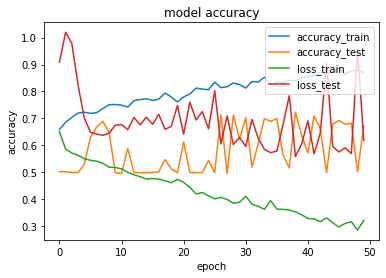

KeyError: 'accuracy_test'

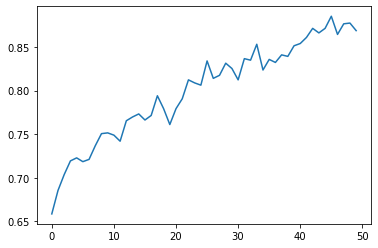

In [5]:
r = ravdess_emodb_emotion_recog("ravdess",2)
r.fit_data()
r.plot_it()
r.predict()

In [31]:
l = ravdess_emodb_emotion_recog("emodb",14)

16a05La
03a01Fa
13b10Wc
12b02Na
16b03Fa
14a05Fa
15b02Wc
15a01Ea
08b01Na
11b02Wb
10a04Wa
14b01Fa
09a02La
16b01Wa
14b02Na
11a02Tc
12a05Ta
03a05Wa
10b03Tb
15b01Wc
08a05Wa
14b01Na
11b09Td
16a02Ec
08a05Ta
13b01Nc
14a04Wb
11a04Wc
08a05Lc
16b03Nb
09b02Wd
03b09La
11b01Ab
03b03Tc
09a05Wb
09a04Nb
15b03Wa
15b10Nb
12a05Nd
14b02Wb
16a05Fc
09b03Ed
14a01Ac
13a04Wc
14a05Tc
08b10Tc
03b10Ab
13a05Ea
15b09Ta
13b01Fc
13a05Aa
16b03Ea
16b09Lb
08a02Fe
15b02Nd
16b02Lb
16a05Ab
08a01Na
11b09Wa
14a07Wc
15a07Ac
08a02Tb
12a02Ec
15b01Na
13b09Fc
14a04Tc
08a07La
03a04Ad
08a02Ab
13b03Ed
10b01Aa
14b03Ed
08a02La
03a05Aa
15b02Aa
09a07Na
11b10Wa
13a01Lb
09b09Nd
12b02Wd
14b09Wc
11b03Td
10a05Wb
14a07Eb
13b03Na
16b09Fb
15b03Wb
03b02Na
14a02Fd
08b03Nb
08b10Wa
12b09Td
14a01Na
14b03Ad
16b10Tb
09a05Ed
11a01Wc
08b09Wa
16b02Eb
15b09Wb
08b02Tc
16b10Wb
11a04Nd
11b01Fc
16a07Td
08b02La
15a02Wb
11a05Td
13a02Ec
13a02Ad
13a04Lb
15a07Ld
10a05Ld
03a04Ta
03b09Tc
16b01Eb
03a07Wc
09a02Wb
15a04Ab
13a07Wb
15a02Ta
15b03Nb
15b02Tc
12b10Wa
15b10Ac
